<a href="https://colab.research.google.com/github/26medias/Stock-Picker/blob/master/Stock_picker_%2B_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Picker + Rolling Sim

## How it works

- Downloader: The class that handles download/caching of the price data
- Picker: The class that picks stocks based on current prices
- Order: The class that converts stock picks into a market order
- Portfolio: The class that handles the current portfolio and their values (broker sim)
- Sim: The main class that runs the sim and invokes all the other classes

## Imports

In [ ]:
!wget https://datahub.io/core/s-and-p-500-companies/r/constituents.csv
!pip install yfinance
!pip install pandas_ta

--2020-10-09 22:31:23--  https://datahub.io/core/s-and-p-500-companies/r/constituents.csv
Resolving datahub.io (datahub.io)... 104.18.48.253, 104.18.49.253, 172.67.157.38, ...
Connecting to datahub.io (datahub.io)|104.18.48.253|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/core/s-and-p-500-companies/constituents_csv/data/652de3c89c39dafdee912fd9cfb23c21/constituents_csv.csv [following]
--2020-10-09 22:31:24--  https://pkgstore.datahub.io/core/s-and-p-500-companies/constituents_csv/data/652de3c89c39dafdee912fd9cfb23c21/constituents_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 172.67.157.38, 104.18.48.253, 104.18.49.253, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|172.67.157.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19096 (19K) [text/csv]
Saving to: ‘constituents.csv.1’

constituents.csv.1  100%[===================>]  18.65K  --.-KB/s    in 0.003s  

2020-10-0

In [ ]:
import sys
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.cluster.hierarchy as spc

import hashlib

import pandas_ta as ta

from os import path
import json
from scipy import stats as scipy_stats
import threading
import time
import math
import random
from IPython.display import HTML, display
import ipywidgets as widgets


pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

## Classes

### Downloader

Returns:
- data
- prices
- returns
- sector_mean

How to use:
```
downloader = Downloader()
downloader.download()
```

In [195]:
class Downloader:
  def __init__(self, figsize=(30,10)):
    self.figsize  = figsize
    self.getStocklist()

  def getStocklist(self):
    self.stocklist = pd.read_csv('constituents.csv')
    self.symbols   = list(self.stocklist[['Symbol']].values.flatten())
    self.sectors   = self.stocklist['Sector'].unique()
  
  def stats(self):
    return self.stocklist.groupby('Sector').aggregate(['count'])
  
  def download(self, sector=None, symbols=None, period='1y'):
    print("Download: ", sector, symbols)
    if sector is not None:
      self.sector = sector
      rows      = self.stocklist[self.stocklist['Sector']==sector]
      symbols   = list(rows[['Symbol']].values.flatten())
      filename  = sector+'.pkl'
      self.symbols = self.getSymbolsBySector(self.sector)
    else:
      if symbols is not None:
        self.symbols = symbols
      filename  = 'data_'+period+'_'+(hashlib.sha224((''.join(self.symbols)).encode('utf-8')).hexdigest())+".json"
    
    if path.exists(filename):
      print("Using cached data")
      self.data = pd.read_pickle(filename)
    else:
      print("Downloading the historical prices")
      self.data = yf.download(self.symbols, period=period, threads=True)
      self.data.to_pickle(filename)
    #self.data = self.data.dropna()
    self.data = self.data[~self.data.index.duplicated(keep='last')]
    self.build()

    return self.data
  
  def getSymbolsBySector(self, sector):
    sectorRows    = self.stocklist[self.stocklist['Sector']==sector]
    return list(sectorRows[['Symbol']].values.flatten())
  
  def build(self):
    self.prices = self.data.loc[:,('Adj Close', slice(None))]
    if math.isnan(self.prices.iloc[0].max()):
      self.data = self.data.iloc[1:]
      self.prices = self.data.loc[:,('Adj Close', slice(None))]
    self.prices.columns = self.symbols
    self.changes  = (self.prices-self.prices.shift())/self.prices.shift()
    self.returns  = (self.prices[:]-self.prices[:].loc[list(self.prices.index)[0]])/self.prices[:].loc[list(self.prices.index)[0]]
    self.sector_mean = self.returns[self.symbols].T.describe().T[['mean']]
    return self.stocklist.groupby('Sector').aggregate(['count'])

downloader = Downloader()
downloader.download()

Download:  None None
[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


Adj Close                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### Picker

Returns:
- returns
- prices
- selected

How to use:
```
picker = Picker(prices=downloader.prices)
picker.pick(count=10)
```

In [34]:
class Picker:
  def __init__(self, prices):
    self.prices = prices
  
  def pick(self, count=5):
    self.returns  = (self.prices[:]-self.prices[:].loc[list(self.prices.index)[0]])/self.prices[:].loc[list(self.prices.index)[0]]
    #print(self.returns)
    stats = pd.DataFrame()
    stats['min'] = self.prices.min()
    stats['max'] = self.prices.max()
    stats['first_price'] = self.prices.iloc[0]
    stats['last_price'] = self.prices.iloc[-1]
    stats['return'] = (stats['last_price']-stats['first_price'])/stats['first_price']
    stats['7d'] = (stats['last_price']-self.prices.iloc[-7])/stats['first_price']
    stats['20d'] = (stats['last_price']-self.prices.iloc[-20])/stats['first_price']
    stats['50d'] = (stats['last_price']-self.prices.iloc[-50])/stats['first_price']
    stats['100d'] = (stats['last_price']-self.prices.iloc[-100])/stats['first_price']
    stats['sharpe'] = (252**0.5) * self.returns.diff().mean() / self.returns.diff().std()
    stats.sort_values(['sharpe'], ascending=[0], inplace=True)
    selected = stats.copy();
    selected = selected[selected['7d'] > 0]
    selected = selected[selected['20d'] > 0]
    selected = selected[selected['sharpe'] > 1]
    selected = selected.head(count)
    self.selected = selected
    return selected

picker = Picker(prices=downloader.prices)
picker.pick(count=10)

,min,max,first_price,last_price,return,7d,20d,50d,100d,sharpe
WRK,128.761703,298.279999,140.449707,298.279999,1.123750,0.160128,0.145319,0.209399,0.628808,2.244688
NUE,182.647690,573.859985,182.647690,550.510010,2.014054,0.032467,0.195020,0.690110,1.051100,2.074517
EXR,89.801018,271.549988,138.992538,271.549988,0.953702,0.125690,0.253323,0.745582,1.118268,1.847352
DHR,120.986763,226.059998,138.145721,226.059998,0.636388,0.082449,0.132568,0.162438,0.487726,1.783524
ABC,1676.609985,3531.449951,1720.260010,3286.649902,0.910554,0.038012,0.106775,0.070902,0.458483,1.758783
ROST,31.462444,57.470001,34.455925,57.470001,0.667928,0.106223,0.092292,0.149413,0.534258,1.655411
COO,255.002869,464.700012,279.950378,464.700012,0.659937,0.094660,0.109305,0.182037,0.442747,1.646487
ABBV,55.840385,134.179993,56.957375,116.970001,1.053641,0.003160,0.028267,0.191393,0.654983,1.627322
OMC,107.151283,204.130005,110.729691,199.759995,0.804033,0.153437,0.059695,0.154210,0.401917,1.591273
TMO,66.967293,154.630005,91.916283,149.929993,0.631158,0.085730,0.128269,0.082301,0.465297,1.589883


### Order

Returns:
- returns
- prices
- selected

How to use:
```
order = Order(prices=downloader.prices, picks=picker.selected)
order.get(budget=5000)
```

In [35]:
class Order:
  def __init__(self, prices, picks):
    self.picks = picks
    self.prices = prices[list(picks.index)]
  
  def get(self, budget=5000):
    weights = {}
    pickWeights = self.picks[['sharpe']].copy()
    pickWeights['weight']      = pickWeights[['sharpe']]/pickWeights[['sharpe']].sum()
    for symbol in list(self.picks.index):
      weights[symbol] = pickWeights.at[symbol, 'weight']#1/len(list(self.picks.index))
    weights = self.toDataFrame(weights)
    orders, leftovers   = self.getOrder(weights, budget)
    #orders.plot.pie(y='budget_weight', figsize=(5, 5))
    orders = pd.concat([orders, self.picks], axis=1)
    self.orders = orders
    self.leftovers = leftovers
    return orders, leftovers

  # Convert a weight dict to a dataframe with latest prices
  def toDataFrame(self, portfolio):
    dfo = {'symbol': [], 'price': [], 'weight': []}
    dfo['symbol'] = list(portfolio.keys())
    last_index  = self.prices.index[-1]
    last_prices = self.prices.loc[last_index]
    dfo['price'] = list(last_prices)
    dfo['weight'] = list(portfolio.values())
    prices = pd.DataFrame.from_dict(dfo)
    prices = prices.set_index('symbol')
    return prices
  
  def filterAffordable(self, affordable, leftover):
    #print('+++++++++++++++')
    #print("filterAffordable("+str(leftover)+")")
    data = affordable.copy();
    # Rebuild the weights
    data['weight']      = data[['weight']]/data[['weight']].sum()
    data['order_size']  = data['weight']*leftover
    data.sort_values(by=['weight'], inplace=True)
    #print(data)
    #print('+++++++++++++++')
    left = data[data['order_size'] >= data['price']]
    if len(left) == 0:
      # Drop the lowest weight
      ndata = data.iloc[1:]
      ndata = ndata.drop(['order_size'], axis=1)

      if len(ndata) == 0:
        return data
      else:
        return self.filterAffordable(ndata, leftover)
    return data

  def getOrder(self, weights, balance=10000, filter=False):
    wdata = weights.copy()
    # Sort by weight asc
    wdata.sort_values(by=['weight'], inplace=True)

    # Calculate the budget & size
    wdata['budget'] = (balance*wdata[['weight']])
    wdata['order_size']  = wdata['budget']/wdata['price']
    wdata['order_size']  = wdata[['order_size']].apply(np.floor)
    wdata['order_value'] = wdata['order_size']*wdata['price']

    # Maximize the invested value
    leftover            = balance - wdata[['order_value']].sum()[0]
    minPrice            = wdata[['price']].min()[0]

    # Filter out what we can't afford
    affordable  = wdata[wdata['price'] <= leftover]
    affordable = affordable.drop(['budget','order_size','order_value'], axis=1)
    # Rebuild the weights
    #affordable['weight'] = affordable[['weight']]/affordable[['weight']].sum()
    #affordable['order_size']  = affordable['weight']*leftover

    affordable = self.filterAffordable(affordable, leftover)

    if len(affordable) > 0:
     
      new_df, leftover  = self.getOrder(affordable, leftover)
      new_df = new_df.dropna()
      # Merge with the new data
      for symbol, row in new_df.iterrows():
        wdata.at[symbol, 'order_size'] = wdata.at[symbol, 'order_size'] + row['order_size']
      
      wdata['order_value'] = wdata['order_size']*wdata['price']
      leftover            = balance - wdata[['order_value']].sum()[0]
      minPrice            = wdata[['price']].min()[0]
    wdata = wdata.dropna()

    if filter == True:
      wdata = wdata[wdata['order_size'] > 0]
    
    wdata['budget_weight'] = wdata[['order_value']]/wdata[['order_value']].sum()
    return wdata, leftover

order = Order(prices=downloader.prices, picks=picker.selected)
order.get(budget=5000)

(            price    weight      budget  order_size  order_value  budget_weight          min          max  first_price   last_price    return        7d       20d       50d      100d    sharpe
 TMO    149.929993  0.089223  446.114099         3.0   449.789978       0.090473    66.967293   154.630005    91.916283   149.929993  0.631158  0.085730  0.128269  0.082301  0.465297  1.589883
 OMC    199.759995  0.089301  446.504100         2.0   399.519989       0.080362   107.151283   204.130005   110.729691   199.759995  0.804033  0.153437  0.059695  0.154210  0.401917  1.591273
 ABBV   116.970001  0.091324  456.619510         5.0   584.850006       0.117640    55.840385   134.179993    56.957375   116.970001  1.053641  0.003160  0.028267  0.191393  0.654983  1.627322
 COO    464.700012  0.092399  461.997014         0.0     0.000000       0.000000   255.002869   464.700012   279.950378   464.700012  0.659937  0.094660  0.109305  0.182037  0.442747  1.646487
 ROST    57.470001  0.092900  464.5

### Portfolio

Returns:
- Unknown

How to use:
```
portfolio = Portfolio()
portfolio.buy(orders=order.orders)
```

In [57]:

class Portfolio:
  def __init__(self, cash=5000, sl=-0.1, tp=0.25):
    self.cash     = cash
    self.sl       = sl
    self.tp       = tp
    self.holdings = pd.DataFrame(columns=['symbol','purchase_date','sell_date','status','purchase_price','current_price','profits','profits_pct'])

  # Refresh the positions with fresh price data
  # Delete the positions that aren't performing well
  def refresh(self, prices, date):
    opened = self.holdings[self.holdings['status']=='open']
    symbols = opened['symbol'].unique()
    for symbol in symbols:
      subsetIds = opened[opened['symbol']==symbol].index
      # Update the holdings
      self.holdings.loc[subsetIds, 'current_price'] = prices[symbol].iloc[-1]
      self.holdings.loc[subsetIds, 'profits']       = self.holdings.loc[subsetIds, 'current_price'] - self.holdings.loc[subsetIds, 'purchase_price']
      self.holdings.loc[subsetIds, 'profits_pct']   = (self.holdings.loc[subsetIds, 'current_price'] - self.holdings.loc[subsetIds, 'purchase_price'])/self.holdings.loc[subsetIds, 'purchase_price']
    
    # Get the ones that are not performing well
    opened = self.holdings[self.holdings['status']=='open']
    poor_perfs  = opened[opened['profits_pct']<=self.sl]
    if len(poor_perfs) > 0:
      sell_list   = poor_perfs['symbol'].unique()
      sell_orders = self.getSellAllOrders(symbols=sell_list)
      #print('')
      #print('-- Poor Performers --')
      #print(poor_perfs)
      self.sell(sell_orders, prices, date)
    
    # Get the ones that are are performing very well
    opened = self.holdings[self.holdings['status']=='open']
    good_perfs  = opened[opened['profits_pct']>=self.tp]
    if len(good_perfs) > 0:
      sell_list   = good_perfs['symbol'].unique()
      sell_orders = self.getSellAllOrders(symbols=sell_list)
      #print('')
      #print('-- Good Performers --')
      #print(good_perfs)
      self.sell(sell_orders, prices, date)

  # Update the holdings based on purchase orders
  def update(self, orders, prices, date):
    #buy_orders, sell_orders = self.computeOrders(orders)
    buy_orders = self.getBuyOrders(orders)
    #print('')
    #print('-- Buy orders --')
    #print(buy_orders)
    self.buy(buy_orders, prices, date)
  
  # Sell All
  def sellAll(self, prices, date, symbols=None):
    sell_orders = self.getSellAllOrders(symbols=symbols)
    return self.sell(sell_orders, prices, date)
  
  def buy(self, buy_orders, prices, date):
    #print("Buy Value", buy_orders.sum()['total_value'])
    for symbol, row in buy_orders.iterrows():
      for i in range(0, int(row['count'])):
        # Pay for the order
        if self.cash >= prices[symbol].iloc[-1]:
          self.cash = self.cash - prices[symbol].iloc[-1]
          #print("Buying 1x "+symbol+" for $"+str(prices[symbol].iloc[-1])+" | Cash: $"+str(self.cash))
          self.holdings = self.holdings.append({
              "symbol":         symbol,
              "purchase_date":  date,
              "sell_date":      None,
              "purchase_price": prices[symbol].iloc[-1],
              "current_price":  prices[symbol].iloc[-1],
              "status":         'open'
          }, ignore_index=True)
        else:
          print("# Not enough cash to purchase "+symbol+" at ", prices[symbol].iloc[-1])
  
  def sell(self, sell_orders, prices, date):
    for symbol, row in sell_orders.iterrows():
      subsetIds = self.holdings[self.holdings['symbol']==symbol]
      subsetIds = subsetIds[subsetIds['status']=='open']
      subsetIds = subsetIds.head(int(row['count'])).index
      # Update the holdings
      self.holdings.loc[subsetIds, 'current_price'] = prices[symbol].iloc[-1]
      self.holdings.loc[subsetIds, 'status']        = 'closed'
      self.holdings.loc[subsetIds, 'profits']       = self.holdings.loc[subsetIds, 'current_price'] - self.holdings.loc[subsetIds, 'purchase_price']
      self.holdings.loc[subsetIds, 'profits_pct']   = (self.holdings.loc[subsetIds, 'current_price'] - self.holdings.loc[subsetIds, 'purchase_price'])/self.holdings.loc[subsetIds, 'purchase_price']
      self.holdings.loc[subsetIds, 'sell_date']     = date
      # Calculate the profits & how much we're getting back out
      subset    = self.holdings[self.holdings.index.isin(subsetIds)]
      self.cash = self.cash + subset['current_price'].sum()
      #print("Selling "+str(len(subsetIds))+"x "+symbol+" for $"+str(subset['current_price'].sum())+" with a $"+str(subset['profits'].sum())+" gain | Cash: $"+str(self.cash))
  
  def computeOrders(self, orders):
    opened = self.holdings[self.holdings['status']=='open'].groupby(['symbol'])
    holding_stats = opened.sum()
    holding_stats['count'] = opened.count()['purchase_date']
    
    # Sell the positions that aren't part of the new portfolio
    sell_list = [i for i in list(holding_stats.index) if i not in list(orders.index)]
    sell_orders = pd.DataFrame()
    if len(sell_list) > 0:
      # Sell those positions entirely
      sell_orders = holding_stats[holding_stats.index.isin(sell_list)].copy()
      sell_orders = sell_orders.drop(columns=['purchase_price','profits'])
      sell_orders['current_price'] = sell_orders['current_price']/sell_orders['count']
      sell_orders['total_value'] = sell_orders['current_price']*sell_orders['count']
    # Find the positions to update
    update_list = [i for i in list(holding_stats.index) if i in list(orders.index)]
    update_order = orders[orders.index.isin(update_list)]
    diff = update_order[['order_size']].copy()
    diff['prev_order_size'] = holding_stats['count']
    diff['diff'] = diff['order_size']-diff['prev_order_size']
    diff['current_price'] = orders[orders.index.isin(diff.index)]['last_price']
    #print('-- diff --')
    #print(diff)
    buy_orders = pd.DataFrame()
    buy_orders['count'] = orders['order_size']
    buy_orders['current_price'] = orders['last_price']
    buy_orders['total_value'] = buy_orders['current_price']*buy_orders['count']
    for symbol, row in diff.iterrows():
      if row['diff'] > 0:
        # Buy
        if symbol in list(buy_orders.index):
          buy_orders.loc[symbol, 'count'] = buy_orders.loc[symbol, 'count'] + row['diff']
        else:
          buy_orders.loc[symbol, 'count'] = row['diff']
      elif row['diff'] < 0:
        # Sell
        if symbol in list(sell_orders.index):
          sell_orders.loc[symbol, 'count'] = sell_orders.loc[symbol, 'count'] + abs(row['diff'])
        else:
          sell_orders.loc[symbol, 'count'] = abs(row['diff'])
        sell_orders.loc[symbol, 'current_price']  = row['current_price']
        sell_orders.loc[symbol, 'total_value']    = row['current_price']*abs(row['diff'])
        buy_orders.loc[symbol, 'count'] = 0
    buy_orders = buy_orders[buy_orders['count'] > 0]
    return buy_orders, sell_orders
  
  def getSellAllOrders(self, symbols=None):
    opened = self.holdings[self.holdings['status']=='open']
    if symbols is not None:
      opened = opened[opened['symbol'].isin(symbols)]
    opened = opened.groupby(['symbol'])
    holding_stats = opened.sum()
    if len(holding_stats) > 0:
      holding_stats['count'] = opened.count()['purchase_date']
      sell_orders = holding_stats.copy()
      sell_orders = sell_orders.drop(columns=['purchase_price','profits'])
      sell_orders['current_price'] = sell_orders['current_price']/sell_orders['count']
      sell_orders['total_value'] = sell_orders['current_price']*sell_orders['count']
      return sell_orders
    return pd.DataFrame()
  
  def getBuyOrders(self, orders):
    buy_orders = pd.DataFrame()
    buy_orders['count'] = orders['order_size']
    buy_orders['current_price'] = orders['last_price']
    buy_orders['total_value'] = buy_orders['current_price']*buy_orders['count']
    buy_orders = buy_orders[buy_orders['count']>0]
    return buy_orders

  def holdingStats(self):
    opened = self.holdings[self.holdings['status']=='open'].copy()
    closed = self.holdings[self.holdings['status']=='closed'].copy()
    openGroup = opened.groupby(['symbol'])
    stats_open = openGroup.sum()
    stats_open['count'] = openGroup.count()['purchase_date']

    closedGroup = closed.groupby(['symbol'])
    stats_closed = closedGroup.sum()
    stats_closed['count'] = closedGroup.count()['purchase_date']
    print("-- Opened --")
    print(stats_open)
    print("-- Closed --")
    print(stats_closed)
  
  def getOrderValue(self, order):
    if len(order):
      data = order.copy();
      data['val'] = data['count']*data['current_price']
      print(data)
      sum = data.sum()['val']
      print("Sum: ", sum)
    else:
      print("None")
  
  def summary(self):
    return {
        "invested":       self.holdings[self.holdings['status']=='open'][['purchase_price']].sum()[0],
        "portfolio_value":self.holdings[self.holdings['status']=='open'][['current_price']].sum()[0],
        "Positions":      len(self.holdings),
        "closed":         len(self.holdings[self.holdings['status']=='closed']),
        "opened":         len(self.holdings[self.holdings['status']=='open']),
        "cash":           self.cash,
        "total_value":    self.holdings[self.holdings['status']=='open'][['current_price']].sum()[0]+self.cash
    }


### Sim

Returns:
- Unknown

How to use:
```
sim = Sim(period='2y', timestep=5, budget=5000)
sim.tick()
```

In [172]:
class Sim:
  def __init__(self, period='2y', timedelay=100, window=100, timestep=5, budget=5000, stockPicks=10, sl=-0.1, tp=0.25):
    self.period     = period
    self.timedelay  = timedelay
    self.timestep   = timestep
    self.budget     = budget
    self.stockPicks = stockPicks
    self.sl         = sl
    self.tp         = tp
    self.portfolio  = Portfolio(cash=budget, sl=self.sl, tp=self.tp)
    self.downloader = Downloader()
    self.downloader.download(period=self.period)
    self.current_index = timedelay
  
  def progress(self, value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 50%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))
  
  def run(self):
    out = display(self.progress(0, 100), display_id=True)
    steps = (len(self.downloader.prices)-self.timedelay)
    stepN = 0
    stats = pd.DataFrame()
    while self.current_index+self.timestep < len(self.downloader.prices):
      output = self.tick()
      output['date'] = self.downloader.prices.index[self.current_index]
      stats = stats.append(output, ignore_index=True)
      #stats.at[self.downloader.prices.index[self.current_index]] = self.tick()
      stepN = stepN + 1
      pct = math.ceil((stepN/steps)*100)
      out.update(self.progress(pct, 100))
    self.portfolio.sellAll(prices=self.downloader.prices[:self.current_index], date=self.downloader.prices.index[self.current_index])
    stats = stats.set_index('date')
    return stats
  
  def tick(self):
    #print('\n\n----------- tick -----------')
    # Get the latest prices
    prices = self.downloader.prices[:self.current_index]
    # Refresh the portfolio with the latest prices, sell what needs to be sold
    self.portfolio.refresh(prices=prices, date=self.downloader.prices.index[self.current_index])
    # Get the portfolio summary
    portfolio_summary = self.portfolio.summary()
    #print('')
    #print('-- Summary after update --')
    #print(portfolio_summary)
    # Pick the stocks
    picker = Picker(prices=prices)
    picker.pick(count=self.stockPicks)
    # Get the order size
    order   = Order(prices=prices, picks=picker.selected)
    order.get(budget=portfolio_summary['cash'])
    # Update our portfolio
    self.portfolio.update(orders=order.orders, prices=prices, date=self.downloader.prices.index[self.current_index])
    # Update the index
    if self.current_index + self.timestep < len(self.downloader.prices):
      self.current_index = self.current_index + self.timestep
    
    portfolio_summary = self.portfolio.summary()
    #print('')
    #print('$', portfolio_summary['total_value'])
    #print('-- End Summary --')
    #print(portfolio_summary)

    return portfolio_summary


## Analysis

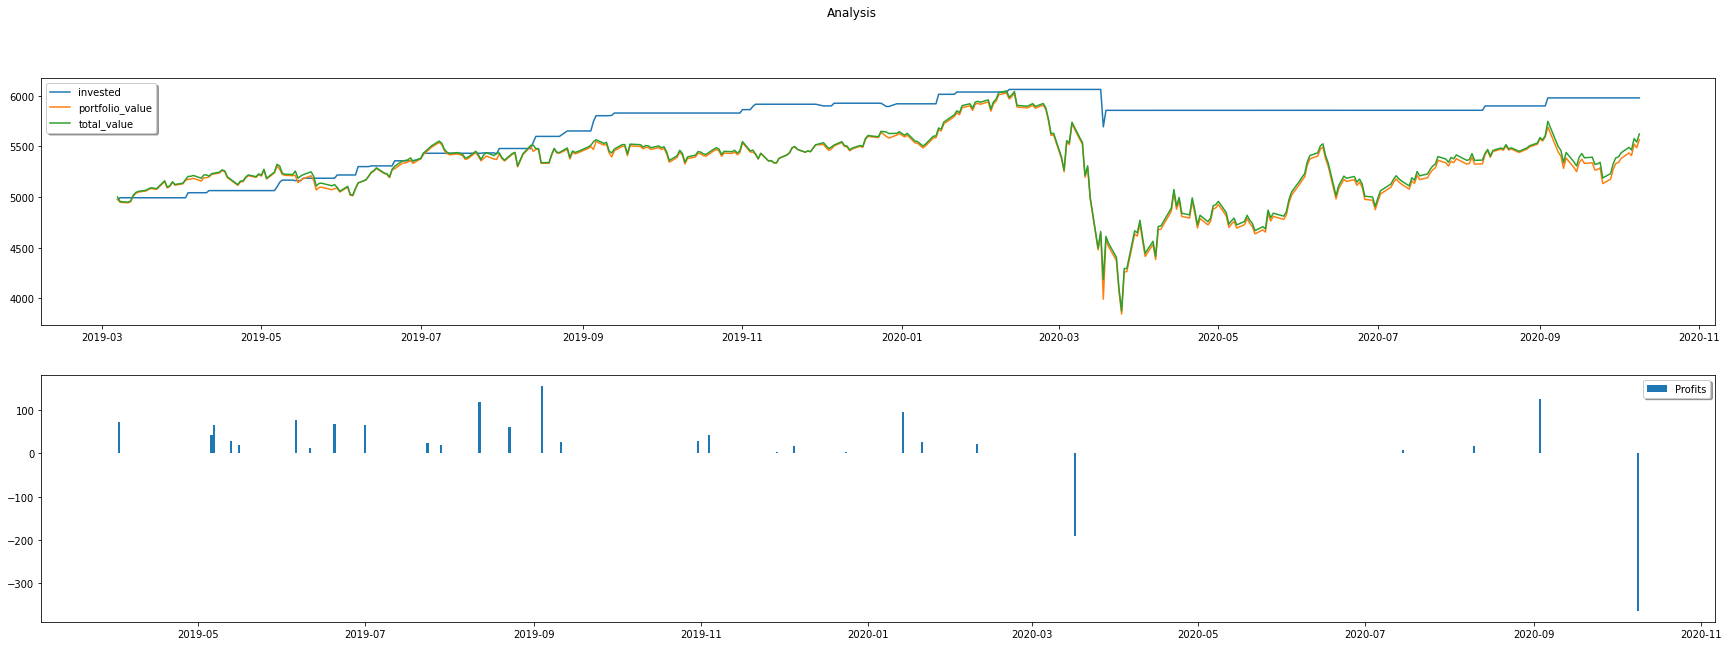

,startValue,endValue,gains,minGain,maxGain,minValue,maxValue,DropFromHigh,riseFromLow,profitRatio,winRate,sharpe
0,5000.0,5623.793593,12.475872,-22.505155,20.99081,3874.74226,6049.540477,0.070377,0.451398,0.426311,79.904306,0.278844


In [224]:
class Analysis:
  def __init__(self, stats, positions):
    self.stats      = stats
    self.positions  = positions
  
  def chart(self):
    #self.stats[['invested','portfolio_value','total_value']].plot(figsize=(30,5))
    fig, axs = plt.subplots(2, figsize=(30,10))
    fig.suptitle('Analysis')
    for col in ['invested','portfolio_value','total_value']:
      axs[0].plot(self.stats[col], label=col)
    
    group = self.positions.copy()
    group = group.set_index('sell_date')
    group = group.groupby(group.index)['profits'].sum()
    profits = pd.DataFrame(index=stats.index, data=np.zeros(len(stats.index)))
    profits['profits'] = group
    axs[1].bar(list(profits['profits'].index), profits['profits'].values, label="Profits")
    #profits[['profits']].plot.bar(figsize=(30,10))

    axs[0].legend(shadow=True, fancybox=True)
    axs[1].legend(shadow=True, fancybox=True)
    plt.show()
  
  def chartPies(self, figsize=(5,5)):
    holdings = self.positions.copy()
    holdings = holdings.groupby('symbol')

    holdings.count().plot.pie(y='purchase_date', figsize=figsize, title="By Shares", legend=False)
    plt.show()

    sums = holdings.sum()

    sums.plot.pie(y='purchase_price', figsize=figsize, title="By Investment", legend=False)
    plt.show()

    in_profit = sums[sums['profits']>0]
    in_profit.plot.pie(y='profits', figsize=figsize, title="Biggest Winners (value)", legend=False)
    plt.show()

    in_loss = sums[sums['profits']<0].copy()
    in_loss['profits'] = abs(in_loss['profits'])
    in_loss.plot.pie(y='profits', figsize=figsize, title="Biggest Losers (value)", legend=False)
    plt.show()

    in_profit.plot.pie(y='profits_pct', figsize=figsize, title="Biggest Winners (Gains)", legend=False)
    plt.show()

    in_loss['profits_pct'] = abs(in_loss['profits_pct'])
    in_loss.plot.pie(y='profits_pct', figsize=figsize, title="Biggest Losers (Loss)", legend=False)
    plt.show()
  
  def sharpe(self):
    total_value = self.stats[['total_value']]
    returns  = (total_value[:]-total_value[:].loc[list(total_value.index)[0]])/total_value[:].loc[list(total_value.index)[0]]
    return ((252**0.5) * returns.diff().mean() / returns.diff().std())['total_value']
  
  def positionStats(self):
    positives = self.positions[self.positions['profits']>0]
    positives = dict(positives.describe()['profits'])
    negatives = self.positions[self.positions['profits']<0]
    negatives = dict(negatives.describe()['profits'])
    _obj = {
        "startValue": self.stats.iloc[0]['total_value'],
        "endValue":   self.stats.iloc[-1]['total_value'],
        "gains":      (self.stats.iloc[-1]['total_value']-self.stats.iloc[0]['total_value'])/self.stats.iloc[0]['total_value']*100,
        "sharpe":     self.sharpe(),
        "winRate":    positives['count']/(positives['count']+negatives['count'])*100,
        "profitRatio":positives['max']/abs(negatives['min']),
        "maxValue":   self.stats['total_value'].max(),
        "minValue":   self.stats['total_value'].min(),
        "maxGain":    (self.stats['total_value'].max()-self.stats.iloc[0]['total_value'])/self.stats.iloc[0]['total_value']*100,
        "minGain":   (self.stats['total_value'].min()-self.stats.iloc[0]['total_value'])/self.stats.iloc[0]['total_value']*100,
        "DropFromHigh":   (self.stats['total_value'].max()-self.stats.iloc[-1]['total_value'])/self.stats['total_value'].max(),
        "riseFromLow":   (self.stats.iloc[-1]['total_value']-self.stats['total_value'].min())/self.stats['total_value'].min(),
    }
    output = pd.DataFrame(columns=['startValue','endValue','gains','minGain','maxGain','minValue','maxValue','DropFromHigh','riseFromLow','profitRatio','winRate','sharpe'])
    output = output.append(_obj, ignore_index=True)
    stats = {
        "positives":  positives,
        "negatives":  negatives,
        "value":      dict(self.stats.describe()['total_value']),
        "profits":    dict(self.positions.describe()['profits_pct']),
    }
    return output, stats






## Testing

Download:  None None
Using cached data


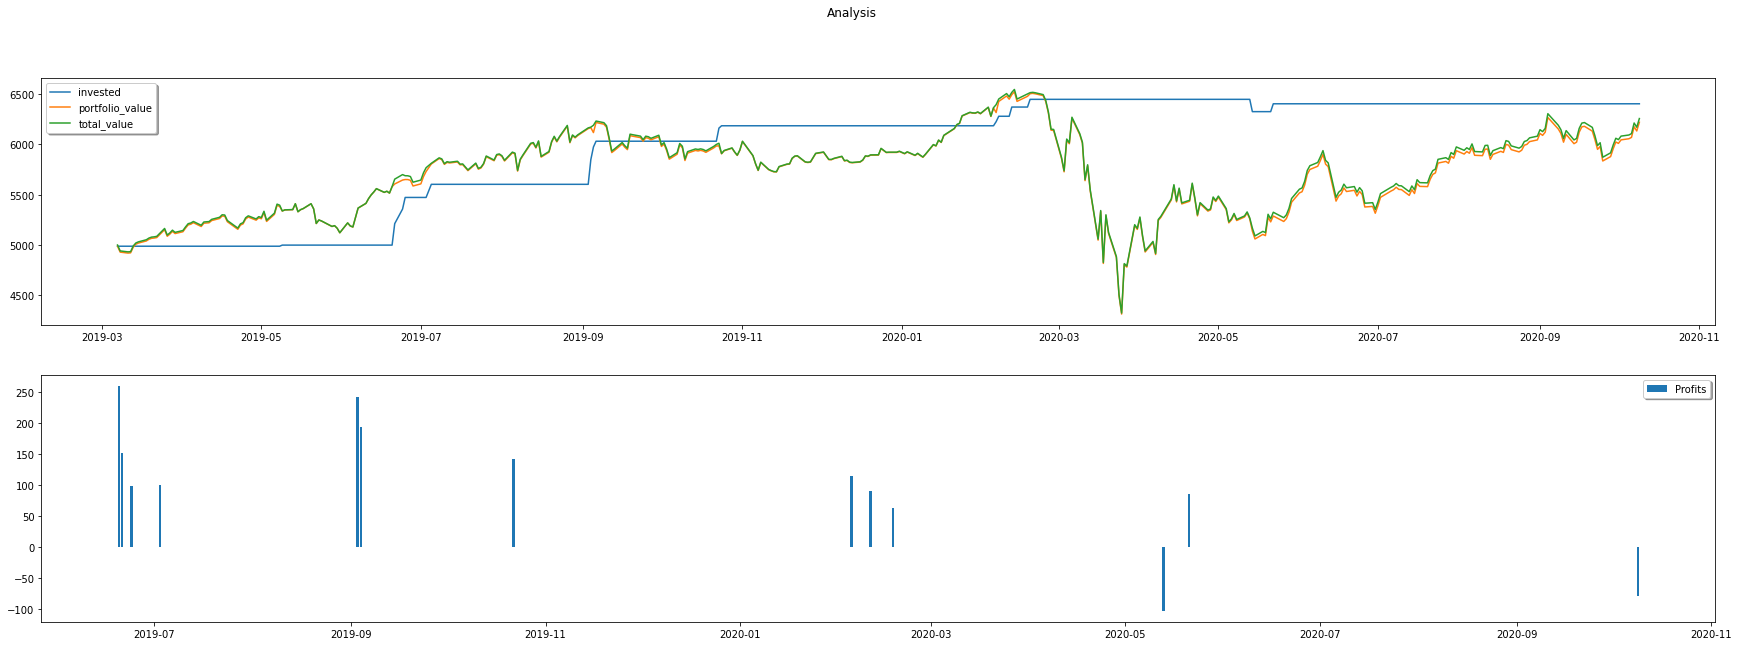

,startValue,endValue,gains,minGain,maxGain,minValue,maxValue,DropFromHigh,riseFromLow,profitRatio,winRate,sharpe
0,5000.0,6258.116556,25.162331,-13.534613,30.955507,4323.269337,6547.775353,0.044238,0.447543,0.746392,69.795918,0.514693


In [226]:
sim = Sim(period='2y', timedelay=100, window=100, timestep=1, budget=5000, sl=-0.5, tp=0.20, stockPicks=10)
#sim.tick()
stats = sim.run()

analysis = Analysis(stats=stats, positions=sim.portfolio.holdings)
analysis.chart()
#analysis.chartPies()
output, advanced_stats = analysis.positionStats()
#print(json.dumps(advanced_stats, indent=4, sort_keys=True))
output